# Game Score v0.2 Notebook

## Started 11/29/23 to update Game Score Calculation

### Improvments
- adds weight for scoring in close games (team +/- 1 goals)
- Adjusts SHOTS score, utilizes both CLose Shots & Even Strength shots 
- Uses +/- for TEAM score - old methodoligy didn't make any sense
- Adds more depth to PENALTY
    - differenciates and wieghts minor penalties and majors differently
    - GOAL but many too much to chew off right now
        - Uses opposing team's PP success rate to weight the PENALTY score
            - seems easy enough to calculate each teams past PP success but it changes from game to game
                


In [19]:
# Dependencies and Setup
import pandas as pd
import numpy as np
import sqlite3

## Connect to Database
path = '../data/db/Nov_27_YTD_Game_Stats.db'
conn = sqlite3.connect(path)

# Check for tables
cursor = conn.cursor()
cursor.execute("SELECT name FROM sqlite_master WHERE type='table';")


# SHOT

In [20]:
# Use the advanced_metrics table to create a dataframe with shots (on_net, missed, blocked) in the EVEN and CLOSE situations

# Load the 'advanced_metrics_combined' table into a DataFrame excluding 'TOTAL' rows
df_amc = pd.read_sql("SELECT * FROM advanced_metrics WHERE player != 'TOTAL'", conn)

# Convert columns to numeric for calculations (replacing empty strings with 0)
columns_to_convert = ['EVEN_Saved', 'EVEN_Goals', 'EVEN_Miss', 'EVEN_Block', 'EVEN_Goals', 
                      'CLOSE_Saved', 'CLOSE_Miss', 'CLOSE_Block', 'CLOSE_Goals', 'CLOSE_Goals',
                        'D_Blocks']
for col in columns_to_convert:
    df_amc[col] = pd.to_numeric(df_amc[col].replace('', '0'))

# Create a new DataFrame with the columns we want to use
shots_df = df_amc[['Team', 'Player', 'Game_ID', 
                   'EVEN_Saved', 'EVEN_Miss', 'EVEN_Block', 'EVEN_Goals',
                   'CLOSE_Saved', 'CLOSE_Miss', 'CLOSE_Block', 'CLOSE_Goals',
                   'D_Blocks']]

# Creat SHOTS ON NET column (Saved + Goals)
shots_df['EVEN_On_Net'] = shots_df['EVEN_Saved'] + shots_df['EVEN_Goals']
shots_df['CLOSE_On_Net'] = shots_df['CLOSE_Saved'] + shots_df['CLOSE_Goals']


# ############ BLOCK TO CALCULATE THE WEIGHTED SHOTS SCORE ############

# SCORE = "CLOSE_On_Net * 0.1 + CLOSE_Miss * 0.08 + CLOSE_Block * 0.05 
#   + EVEN_On_Net * 0.1 + EVEN_Miss * 0.08 + EVEN_Block * 0.05 (NOT D_Blocks - Going to Use in TEAM COMPONANT)"

# Do the calualtions for the weighted shots score and add it to the DataFrame
shots_df['EVEN_Score'] = shots_df['EVEN_On_Net'] * 0.1 + shots_df['EVEN_Miss'] * 0.08 + shots_df['EVEN_Block'] * 0.05
shots_df['CLOSE_Score'] = shots_df['CLOSE_On_Net'] * 0.1 + shots_df['CLOSE_Miss'] * 0.08 + shots_df['CLOSE_Block'] * 0.05

# Add the EVEN and CLOSE scores together to get the total weighted shots score
shots_df['SHOT_Score'] = shots_df['EVEN_Score'] + shots_df['CLOSE_Score']


# shots_df.head()

C:\Users\Justin\AppData\Local\Temp\ipykernel_19212\3030538610.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  shots_df['EVEN_On_Net'] = shots_df['EVEN_Saved'] + shots_df['EVEN_Goals']
C:\Users\Justin\AppData\Local\Temp\ipykernel_19212\3030538610.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  shots_df['CLOSE_On_Net'] = shots_df['CLOSE_Saved'] + shots_df['CLOSE_Goals']
C:\Users\Justin\AppData\Local\Temp\ipykernel_19212\3030538610.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy

# FACEOFF

In [21]:
# Calulate Faceoff Score
# SCORE = "Faceoff_Wins * 0.075 - Faceoff_Losses * 0.075"

# Create a new DataFrame with the columns we want to use from player_stats table in the database
df_fo = pd.read_sql("SELECT Team, Player, Game_ID, FOW, FOL FROM player_stats", conn)

# Convert columns to numeric for calculations (replacing empty strings with 0)
columns_to_convert = ['FOW', 'FOL']
for col in columns_to_convert:
    df_fo[col] = pd.to_numeric(df_fo[col].replace('', '0'))

# Do the calualtions for the faceoff score and add it to the DataFrame
df_fo['FACEOFF_Score'] = df_fo['FOW'] * 0.075 - df_fo['FOL'] * 0.075

# Fil Nan values with 0
df_fo = df_fo.fillna(0)

df_fo.head()
# df_fo.info()


,Team,Player,Game_ID,FOW,FOL,FACEOFF_Score
0,Michigan State,Gavin O'Connell,2023-10-07-Lake Superior-Michigan State,0.0,0.0,0.0
1,Michigan State,Tommi Männistö,2023-10-07-Lake Superior-Michigan State,0.0,0.0,0.0
2,Michigan State,Maxim Štrbák,2023-10-07-Lake Superior-Michigan State,0.0,0.0,0.0
3,Michigan State,Artyom Levshunov,2023-10-07-Lake Superior-Michigan State,0.0,0.0,0.0
4,Michigan State,Patrick Geary,2023-10-07-Lake Superior-Michigan State,0.0,0.0,0.0


# TEAM
## +/- *.25 + Blocked Shots * .1

In [22]:
# Calculate TEAM Score 
# Plus-Minus + Defensive Blocks

# Get plus_minus from player_stas table
df_plus_minus = pd.read_sql("SELECT * FROM player_stats WHERE player != 'TOTAL'", conn)
# Simplify the DataFrame to only the columns we need
df_plus_minus = df_plus_minus[['Team', 'Player', 'Game_ID', 'plus_minus']]

# Get Defensive block column from previous dataframe (df_amc)
df_blocks = df_amc[['Team', 'Player', 'Game_ID', 'D_Blocks']]

# Merge the two DataFrames together
df_team = pd.merge(df_plus_minus, df_blocks, how='outer', on=['Team', 'Player', 'Game_ID'])

# Fill any NaN values with 0
df_team = df_team.fillna(0)
# Convert D_Blocks to to int
df_team['D_Blocks'] = df_team['D_Blocks'].astype(int)
# Conver plus_minus to int
df_team['plus_minus'] = df_team['plus_minus'].astype(int)



df_team['TEAM_Score'] = df_team['plus_minus'] * 0.25 + df_team['D_Blocks'] * 0.1

# df_team.sample(25)
# df_team.info()

# df_blocks.info()

# Penalty

In [23]:
# SUB FUNCTION To calculate the the Overall Power Play Success Rate for entire dataset
# - Used to Weight the PENALTY_SCORE

# Count the total number of Power Play (PP) goals from the scoring_summary table.
pp_goals_count = cursor.execute("SELECT COUNT(*) FROM scoring_summary WHERE PP != '';").fetchone()[0]
# Count the total number of Power Plays from the penalty_summary table.
total_pp_count = cursor.execute("SELECT COUNT(*) FROM penalty_summary;").fetchone()[0]
# Calculate the Power Play success rate.
pp_success_rate = pp_goals_count / total_pp_count

## OVERALL NCAA WIDE POWER PLAY SUCCESS RATE TO USE IN FACTOR
print(f'Overall PP % All Games: {pp_success_rate}')


Overall PP % All Games: 0.25161812297734626


In [24]:
# Use Penalty Summary table to get every individual penalty incident
## Count and differentiate between minor and major penalties

# Load the 'penalty_summary' table into a DataFrame
df_pen = pd.read_sql("SELECT * FROM penalty_summary", conn)

# Create Two Columns to count the number of minor and major penalties
df_pen['Minor_Pen'] = np.where(df_pen['Pen_Length'] == '2', 1, 0)
df_pen['Major_Pen'] = np.where(df_pen['Pen_Length'] == '5', 1, 0)

# Group by player, team, and game_id to get the total number of minor and major penalties
df_pen = df_pen.groupby(['Player', 'Team', 'Game_ID']).agg({'Minor_Pen': 'sum', 'Major_Pen': 'sum'}).reset_index()

# Calulate the Penalty Score
# SCORE = "Penalty_Score = Minor_Pen * pp_succes_rate + Major_Pen * pp_success_rate * 2.5"
df_pen['PENALTY_Score'] = df_pen['Minor_Pen'] * pp_success_rate + df_pen['Major_Pen'] * pp_success_rate * 2.5

# df_pen.head(50)
# df_pen.info()

# # How many players have a major penalty?
# df_pen[df_pen['Major_Pen'] > 0].count()

# SCORING

### Method
- use the scoring_summary table to get all scoring incidents
- Identify Scoring Incidents in CLOSE Games - 1 goal game +/-
    - Store as C_Goal, C_Asst1, C_Asst2
- Indentify Scoring that was shorthanded (PP Column will be 'SH')
    - Store as SH_Goal, SH_Asst1, SH_Asst2


In [25]:
# Create SCORING Score using the scoring_summary table

# Load the 'scoring_summary' table into a DataFrame
df_scoring = pd.read_sql("SELECT * FROM scoring_summary", conn)

# Going to Classify Goals and Assists based on game situation so we can weight them differently

# Shorthanded Goals
# df_scoring['SH_Goal'] = np.where(df_scoring['SH'] == 'SH', 1, 0)

# - Identify Scoring Incidents in CLOSE Games - 1 goal game +/-
    # - Store as C_Goal, C_Asst1, C_Asst2

# Out put CSV to TEMP folder for inspection
df_scoring.to_csv('../TEMP/df_scoring.csv')


In [26]:
import pandas as pd
from collections import defaultdict

# Function to update and check scores for close game situation
def update_and_check_score(row, game_scores):
    game_id = row['Game_ID']
    team = row['Team']

    # Ensure the game has exactly two teams
    if len(game_scores[game_id]['teams']) != 2:
        return False  # Cannot determine close game status without knowing both teams

    # Identify the other team
    other_team = game_scores[game_id]['teams'][0] if team != game_scores[game_id]['teams'][0] else game_scores[game_id]['teams'][1]

    # Update the score for the scoring team
    game_scores[game_id]['scores'][team] += 1

    # Calculate score difference
    score_diff = abs(game_scores[game_id]['scores'][team] - game_scores[game_id]['scores'][other_team])

    # Check if it's a close game situation
    return score_diff <= 1

# Load the dataframe
df_scoring_full = df_scoring

# Prepare to track scores for each game
teams_per_game = df_scoring_full.groupby('Game_ID')['Team'].unique()
game_scores = defaultdict(lambda: {'teams': [], 'scores': {}})

# Initialize score tracking for each game
for game_id, teams in teams_per_game.items():
    if len(teams) == 2:  # Ensure only games with two teams are processed
        game_scores[game_id] = {'teams': teams.tolist(), 'scores': {team: 0 for team in teams}}

# Process each scoring incident and identify close games and shorthanded goals
df_scoring_full['Close_Game'] = df_scoring_full.apply(lambda row: update_and_check_score(row, game_scores), axis=1)
df_scoring_full['SH_Scoring'] = df_scoring_full['PP'] == 'SH'




In [28]:
# Creating the aggregated dataframe

# Grouping and aggregating data
aggregated_data = df_scoring_full.groupby(['Player', 'Team', 'Game_ID']).agg(
    Short_Goals=pd.NamedAgg(column='SH_Scoring', aggfunc=lambda x: sum(x)),
    Close_Goals=pd.NamedAgg(column='Close_Game', aggfunc=lambda x: sum(x)),
    Other_Goals=pd.NamedAgg(column='SH_Scoring', aggfunc=lambda x: len(x) - sum(x))
)

# Adding assist columns
for assist_col in ['Assist1', 'Assist2']:
    aggregated_data[f'Short_{assist_col}'] = df_scoring_full[df_scoring_full['SH_Scoring']].groupby(['Player', 'Team', 'Game_ID'])[assist_col].count()
    aggregated_data[f'Close_{assist_col}'] = df_scoring_full[df_scoring_full['Close_Game']].groupby(['Player', 'Team', 'Game_ID'])[assist_col].count()
    aggregated_data[f'Other_{assist_col}'] = df_scoring_full.groupby(['Player', 'Team', 'Game_ID'])[assist_col].count() - \
                                              df_scoring_full[df_scoring_full['Close_Game']].groupby(['Player', 'Team', 'Game_ID'])[assist_col].count()

# Resetting index
aggregated_data.reset_index(inplace=True)

# Displaying the first few rows of the aggregated dataframe
aggregated_data.head()




,Player,Team,Game_ID,Short_Goals,Close_Goals,Other_Goals,Short_Assist1,Close_Assist1,Other_Assist1,Short_Assist2,Close_Assist2,Other_Assist2
0,A.J. Hodges,Bentley,2023-10-07-Boston University-Bentley,0,1,1,NaN,1.0,0.0,NaN,1.0,0.0
1,A.J. Hodges,Bentley,2023-10-28-Bentley-Robert Morris,0,0,1,NaN,NaN,NaN,NaN,NaN,NaN
2,A.J. Hodges,Bentley,2023-11-10-Niagara-Bentley,0,1,3,NaN,1.0,2.0,NaN,1.0,2.0
3,A.J. Macaulay,Alaska,2023-11-03-Alaska-Anchorage-Alaska,0,0,1,NaN,NaN,NaN,NaN,NaN,NaN
4,Aaron Bohlinger,Massachusetts,2023-10-13-Michigan-Massachusetts,0,0,1,NaN,NaN,NaN,NaN,NaN,NaN


In [36]:
### Calculate SCORING Score

score_df = aggregated_data

# Fill Nan values with 0
score_df = score_df.fillna(0)

non_int_cols = ['Player', 'Team', 'Game_ID']

# Convert all columns to int except for non_int_cols
for col in score_df.columns:
    if col not in non_int_cols:
        score_df[col] = score_df[col].astype(int)

# Calculate the Scoring Score
## Factors - GOALS = .555, ASSIST1 = .455, ASSIST2 = .355
## CLOSE GAME MULTIPLIER = 1.5
## SH GOAL MULTIPLIER = 1.75

score_df['SCORING_Score'] = score_df['Close_Goals'] * 1.5 * 0.555 + score_df['Close_Assist1'] * 1.5 * 0.455 + score_df['Close_Assist2'] * 1.5 * 0.355 + \
                            score_df['Short_Goals'] * 1.75 * 0.555 + score_df['Short_Assist1'] * 1.75 * 0.455 + score_df['Short_Assist2'] * 1.75 * 0.355 + \
                            score_df['Other_Goals'] * 0.555 + score_df['Other_Assist1'] * 0.455 + score_df['Other_Assist2'] * 0.355

score_df.head()



,Player,Team,Game_ID,Short_Goals,Close_Goals,Other_Goals,Short_Assist1,Close_Assist1,Other_Assist1,Short_Assist2,Close_Assist2,Other_Assist2,SCORING_Score
0,A.J. Hodges,Bentley,2023-10-07-Boston University-Bentley,0,1,1,0,1,0,0,1,0,2.6025
1,A.J. Hodges,Bentley,2023-10-28-Bentley-Robert Morris,0,0,1,0,0,0,0,0,0,0.5550
2,A.J. Hodges,Bentley,2023-11-10-Niagara-Bentley,0,1,3,0,1,2,0,1,2,5.3325
3,A.J. Macaulay,Alaska,2023-11-03-Alaska-Anchorage-Alaska,0,0,1,0,0,0,0,0,0,0.5550
4,Aaron Bohlinger,Massachusetts,2023-10-13-Michigan-Massachusetts,0,0,1,0,0,0,0,0,0,0.5550


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2203 entries, 0 to 2202
Data columns (total 13 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Player         2203 non-null   object 
 1   Team           2203 non-null   object 
 2   Game_ID        2203 non-null   object 
 3   Short_Goals    2203 non-null   int32  
 4   Close_Goals    2203 non-null   int32  
 5   Other_Goals    2203 non-null   int32  
 6   Short_Assist1  2203 non-null   int32  
 7   Close_Assist1  2203 non-null   int32  
 8   Other_Assist1  2203 non-null   int32  
 9   Short_Assist2  2203 non-null   int32  
 10  Close_Assist2  2203 non-null   int32  
 11  Other_Assist2  2203 non-null   int32  
 12  SCORING_Score  2203 non-null   float64
dtypes: float64(1), int32(9), object(3)
memory usage: 146.4+ KB


,Player,Team,Game_ID,Short_Goals,Close_Goals,Other_Goals,Short_Assist1,Close_Assist1,Other_Assist1,Short_Assist2,Close_Assist2,Other_Assist2,SCORING_Score
1434,Matt Crasa,Lowell,2023-10-20-Mass.-Lowell-Colgate,0,2,4,0,2,2,0,2,2,7.93500
1241,Lane Hutson,Boston University,2023-11-04-North Dakota-Boston University,0,3,3,0,3,0,0,3,0,7.80750
2013,Tanner Latsch,Northern Michigan,2023-10-13-Northern Michigan-Minnesota-Duluth,0,3,3,0,3,0,0,3,0,7.80750
345,Carter King,Denver,2023-11-10-Denver-Arizona State,2,2,0,2,2,0,1,1,0,7.71875
1892,Ryland Mosley,Michigan Tech,2023-11-04-Augustana-Michigan Tech,0,3,3,0,3,0,0,2,0,7.27500
1166,Karsen Dorwart,Michigan State,2023-10-26-Michigan State-Boston College,1,2,1,1,2,0,1,2,0,7.03875
113,Artem Shlaine,Northern Michigan,2023-11-10-Lake Superior-Northern Michigan,0,2,3,0,2,1,0,2,1,6.57000
30,Aiden Fink,Penn State,2023-11-18-Penn State-Michigan,0,2,3,0,2,1,0,2,1,6.57000
644,Ethan Phillips,Western Michigan,2023-10-12-Ferris State-Western Michigan,0,2,3,0,2,1,0,2,1,6.57000
52,Alex Jefferies,Merrimack,2023-11-10-Merrimack-Connecticut,0,2,3,0,2,1,0,2,1,6.57000


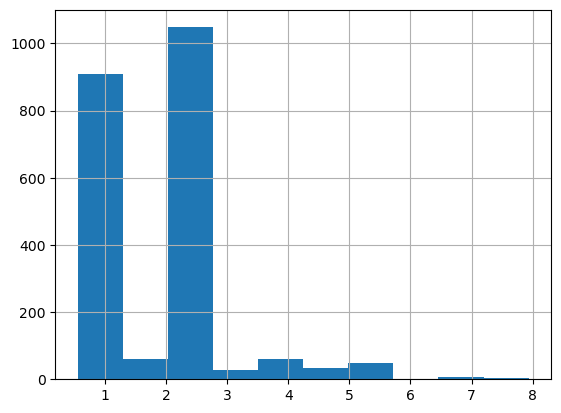

In [38]:
## Examine Output 

# Histogram of Scoring Score
score_df['SCORING_Score'].hist()


score_df.info()

# Sort by Scoring Score and show top 25
score_df.sort_values(by='SCORING_Score', ascending=False).head(25)

# Value Counts for Short_Assist2
# score_df['Short_Assist2'].value_counts()

## Combine to single dataframe

In [29]:
### COMBINE ALL THE DATAFRAMES TOGETHER

# Merge the shots_df and df_fo DataFrames together
df_combined = pd.merge(shots_df, df_fo, how='outer', on=['Team', 'Player', 'Game_ID'])

# Merge the df_combined and df_team DataFrames together
df_combined = pd.merge(df_combined, df_team, how='outer', on=['Team', 'Player', 'Game_ID'])

# Merge the df_combined and df_pen DataFrames together
df_combined = pd.merge(df_combined, df_pen, how='outer', on=['Team', 'Player', 'Game_ID'])

# Fill any NaN values with 0
df_combined = df_combined.fillna(0)

# Filter To Just The SCORE Columns
keep_col = ['Team', 'Player', 'Game_ID', 'SHOT_Score', 'FACEOFF_Score', 'TEAM_Score', 'PENALTY_Score']
df_combined = df_combined[keep_col]

# Calulate the TOTAL Score
## SCORE = "TOTAL_Score = SHOT_Score + FACEOFF_Score + TEAM_Score - PENALTY_Score"
df_combined['TOTAL_Score'] = df_combined['SHOT_Score'] + df_combined['FACEOFF_Score'] + df_combined['TEAM_Score'] - df_combined['PENALTY_Score']

df_combined.head(10)

df_combined.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32047 entries, 0 to 32046
Data columns (total 8 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Team           32047 non-null  object 
 1   Player         32047 non-null  object 
 2   Game_ID        32047 non-null  object 
 3   SHOT_Score     32047 non-null  float64
 4   FACEOFF_Score  32047 non-null  float64
 5   TEAM_Score     32047 non-null  float64
 6   PENALTY_Score  32047 non-null  float64
 7   TOTAL_Score    32047 non-null  float64
dtypes: float64(5), object(3)
memory usage: 2.0+ MB


array([[<Axes: title={'center': 'SHOT_Score'}>,
        <Axes: title={'center': 'FACEOFF_Score'}>],
       [<Axes: title={'center': 'TEAM_Score'}>,
        <Axes: title={'center': 'PENALTY_Score'}>],
       [<Axes: title={'center': 'TOTAL_Score'}>, <Axes: >]], dtype=object)

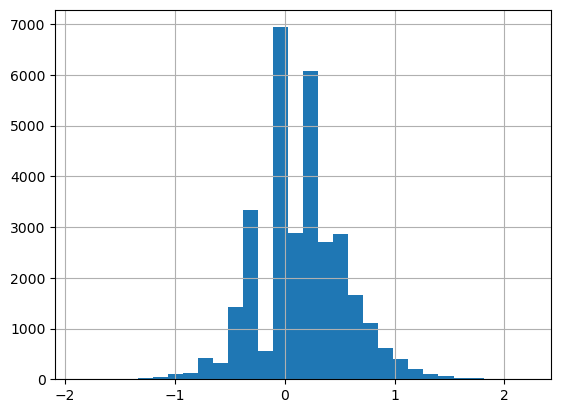

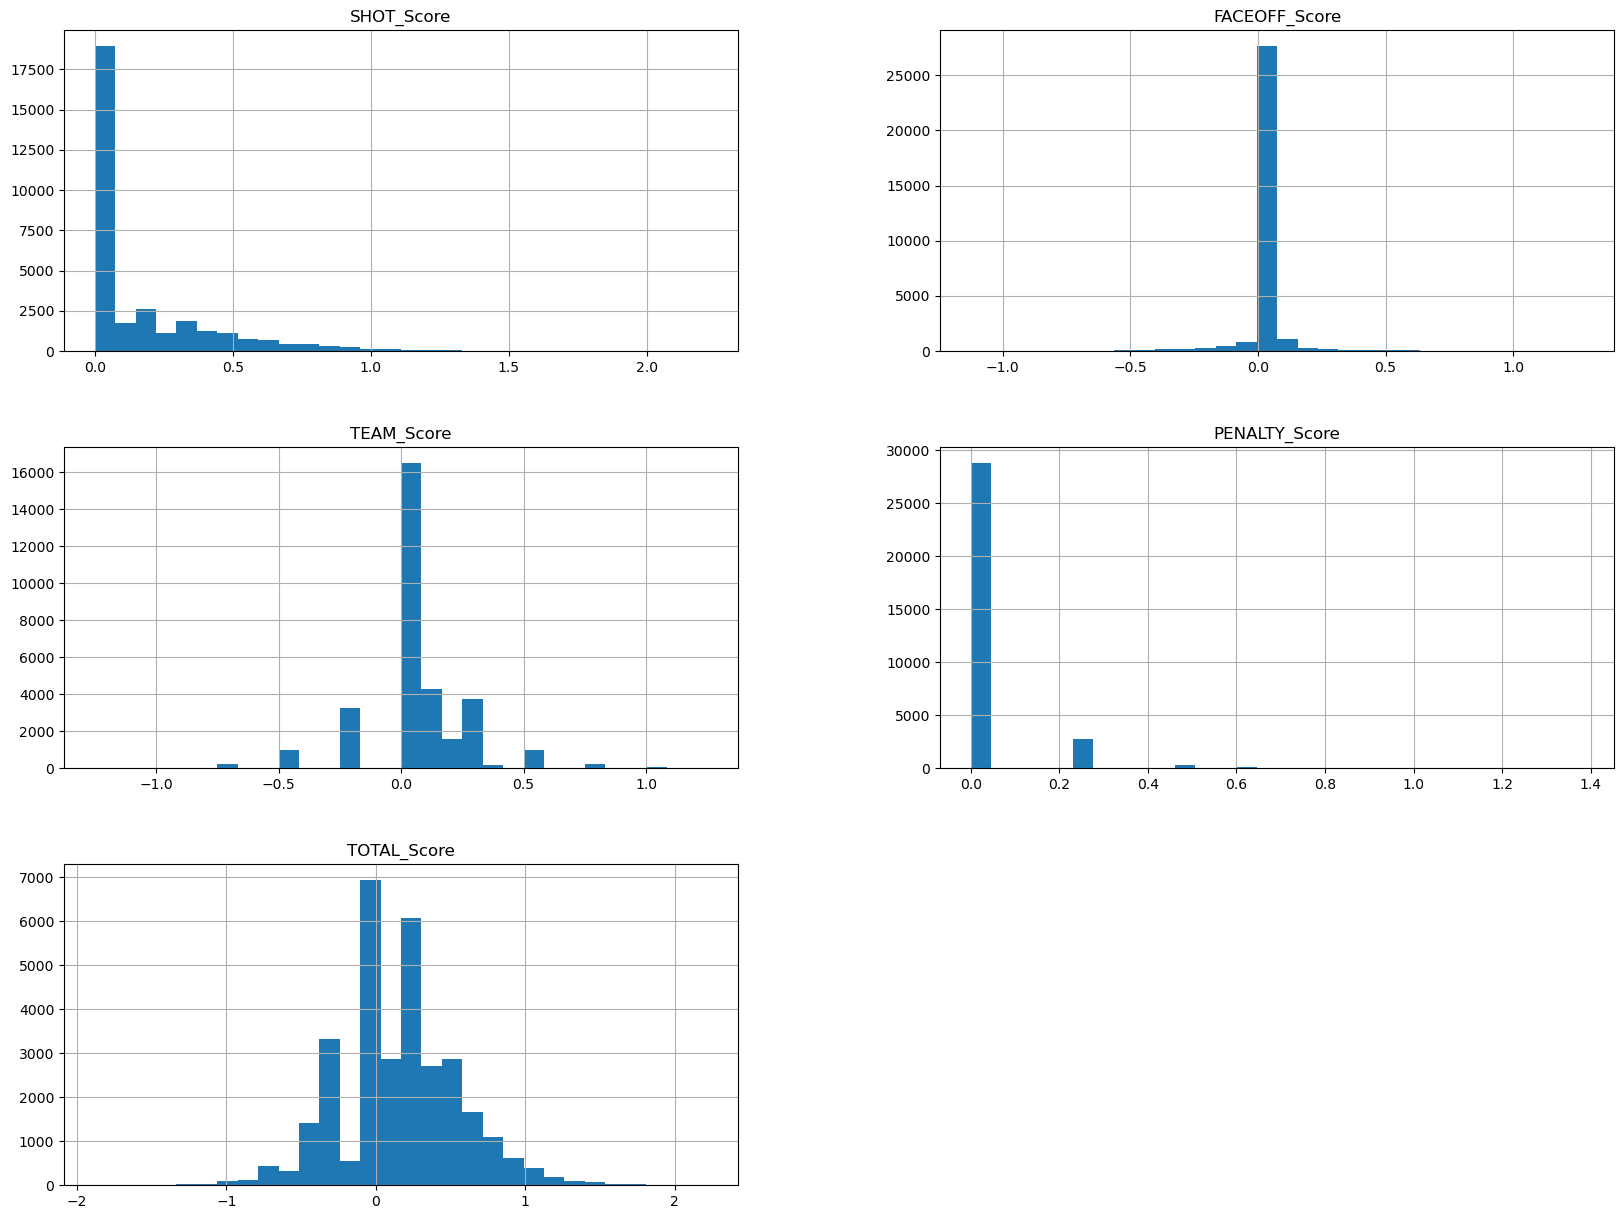

In [30]:
# Score Distribution
df_combined['TOTAL_Score'].describe()

 # Histogram Plot of Score Distribution
df_combined['TOTAL_Score'].hist(bins=30)

# Histograms of all the scores
df_combined.hist(bins=30, figsize=(20,15))